In [1]:
import numpy as np
import stumpy
from datetime import datetime, timedelta
from icecream import ic
from tqdm import tqdm
import arrow
from dateutil import tz

timezone = tz.gettz("Asia/Tokyo")

In [2]:
def read_database(start=2016, stop=2024):
    db = {}
    for year in tqdm(np.arange(start, stop + 1, 1), desc="Reading database"):
        y = np.load(f"data/ntt_mss_{year}.npy")
        mids = np.load(f"data/ntt_mss_{year}_areas.npy")
        db[year] = (y, mids)
    return db

In [3]:
def join_database_of_meshcode(db, meshcode):
    for key in db.keys():
        meshids = db[key][1]
        try:
            pos = np.where(meshids == meshcode)[0].item()
        except:
            print(f"Meshcode {meshcode} not found in {key}")
            return None
        if key == 2016:
            data = db[key][0][:,pos]
        else:
            data = np.concatenate((data, db[key][0][:,pos]), axis=0)
    return data

In [4]:
def set_vars(cur):
    target_year = cur.year
    target_month = cur.month
    target_day = cur.day
    target_hour = cur.hour
    return target_year, target_month, target_day, target_hour

In [5]:
def get_date_one_month_ago(target_year, target_month, target_day, target_hour):
    to_date = arrow.get(target_year, target_month, target_day, target_hour)
    last_month = to_date.shift(months=-1)
    return last_month.datetime

In [6]:
def end_of_year_bool(year1,year2):
    if year1 != year2:
        return True
    else:
        return False

In [7]:
def get_hours(start_year, start_month, start_day, start_hour, stop_year, stop_month, stop_day, stop_hour):
    start = datetime(start_year, start_month, start_day, start_hour, 0, 0, 0, tzinfo=timezone)
    stop = datetime(stop_year, stop_month, stop_day, stop_hour, 0, 0, 0, tzinfo=timezone)
    delta = stop - start
    return delta.days * 24 + delta.seconds // 3600


def get_dateindex(dt, num_days):
    index = sum(num_days[:dt.year-2016]) + get_hours(dt.year,1,1,0,dt.year,dt.month,dt.day,dt.hour)
    return index


def get_history_data(data, num_days, cur, last_month, eoy_bool, alpha=0):
    if eoy_bool:
        alpha = 1
    for i, year in enumerate(np.arange(2016, last_month.year)):
        start_index = get_dateindex(datetime(year,last_month.month,last_month.day,last_month.hour,0,0,0,timezone), num_days)
        stop_index = get_dateindex(datetime(year+alpha,cur.month,cur.day,cur.hour,0,0,0,timezone), num_days)
        if i == 0:    
            history_data = data[start_index:stop_index]
        else:
            history_data = np.concatenate((history_data, data[start_index:stop_index]), axis=0)
    return history_data

In [8]:
def andes(data, num_days, cur, stream_point, meshcode):    
    target_year, target_month, target_day, target_hour = set_vars(cur)
    last_month = get_date_one_month_ago(target_year, target_month, target_day, target_hour)
    eoy_bool = end_of_year_bool(target_year, last_month.year)
    history_data = get_history_data(data, num_days, cur, last_month, eoy_bool)
    # convert data to float64 and replace -1 with np.nan
    history_data = np.where(history_data == -1, np.nan, history_data).astype(np.float64)
    stream_point = np.where(stream_point == -1, np.nan, stream_point).astype(np.float64)
    # calculate the left matrix profile
    T = history_data
    m = 3
    stream = stumpy.stumpi(T, m, normalize=False, egress=False)
    # update stream with new data
    stream.update(stream_point)
    # calculate the left MP
    a = stream._left_P[m:]
    # filter initial 'inf' values
    af = a[np.isfinite(a)]
    # calculate std of the left MP ==> Condition for anomaly detection
    return stream._left_P[-1] > (af.mean() + 4 * af.std())

## Load Database

In [9]:
# YOU MAY RUN THIS ONCE TO LOAD THE DATABASE
db = read_database(start=2016, stop=2024)

Reading database: 100%|██████████| 9/9 [01:49<00:00, 12.19s/it]


# RUN FROM HERE

In [23]:
# INPUT CASES
cur = datetime(2024,2,15,10,0,0,0,timezone) # Random non populated area
meshcode = 564010771
cur = datetime(2024,1,1,16,0,0,0,timezone) # Noto EQ @ Suzu
meshcode = 563712214
cur = datetime(2018,7,7,1,0,0,0,timezone) # Kurashiki Flood
meshcode = 513375542
cur = datetime(2022,3,16,23,0,0,0,timezone) # Fukushima EQ
meshcode = 574007523
cur = datetime(2019,10,12,16,0,0,0,timezone) # Koriyama Flood
meshcode = 564003523
cur = datetime(2024,7,8,0,0,0,0,timezone) # Wakayama Heavy Rain (Wakayama Sta., 513521831)
meshcode = 513521831 
cur = datetime(2024,1,1,16,0,0,0,timezone) # Noto EQ @ Wajima
meshcode = 563607723 #563607621 #563607721

In [24]:
# THESE ARE NECESSARY BY MESHCODE (OFFLINE)
# get all years data together for the target meschode
data = join_database_of_meshcode(db, meshcode)
# create a list with shape of database for each year, number of hours per year
num_days = [db[key][0].shape[0] for key in db.keys()]

### Algorithm 1 - One Point data

In [25]:
# THIS IS SUPPOSED TO COME ONLINE - record at current time - here we take it from the database (ONLINE)
cur_index = get_dateindex(cur, num_days)
stream_point = data[cur_index]
andes(data, num_days, cur, stream_point, meshcode)

np.False_

### Algorithm 2 - Multiple point data

In [26]:
# TEST CASE FOR MULTIPLE DAYS
# create a list of dates for the last 10 hours
xhours = 4 * 24
dates_before = [cur - timedelta(hours=i) for i in range(xhours,0,-1)]
dates_after = [cur + timedelta(hours=i) for i in range(xhours)]
dates = dates_before + dates_after
img = []
for date in dates:
    # this is input data
    cur_index = get_dateindex(date, num_days)
    stream_point = data[cur_index]
    meschode = meshcode
    # online anomaly detection
    anomaly = andes(data, num_days, date, stream_point, meshcode)
    img.append(anomaly)
    if anomaly:
        ic(date)

ic| date: datetime.datetime(2024, 1, 1, 17, 0, tzinfo=tzfile('/usr/share/zoneinfo/Asia/Tokyo'))


In [27]:
arr = np.array(img).astype(int)
# add to arr cur.hours points of np.nan at the beginning
arr = np.concatenate((np.full(dates[0].hour, np.nan), arr))
arr = np.concatenate((arr,np.full((23 - dates[-1].hour), np.nan)))

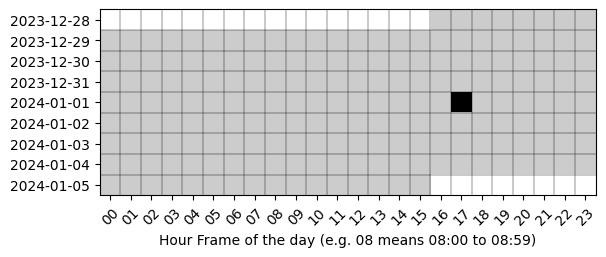

In [28]:
import matplotlib.pyplot as plt

plt.imshow(arr.reshape(-1,24), cmap='nipy_spectral_r')
days = set([dates[i].date() for i in range(len(dates))])
# set up y ticks labels
plt.yticks(np.arange(0,len(days)), [f"{i}" for i in sorted(days)])
plt.xticks(np.arange(0,24), [f"{i:02d}" for i in np.arange(0,24)], rotation=45);
# create vertical lines at 0.5 of each hour
for i in range(1,24):
    plt.axvline(i-0.5, color='black', linewidth=0.3)
# create horizontal lines at 0.5 of each hour
for i in range(1,len(days)):
    plt.hlines(i-0.5, xmin=-0.5,xmax=23.5,color='black', linewidth=0.3)
plt.xlabel("Hour Frame of the day (e.g. 08 means 08:00 to 08:59)")
plt.savefig("andes.png", dpi=300)